# Exploring OOI data access

Still not sure how everything works, so this script is going to be my exploration into loading broadband hydrophone data.

I'm using this notebook as an example: https://github.com/petercable/noisy-dolphins/blob/master/Voices.ipynb 

But rather than loading up one specific file, I'm interested in providing the user with a way to explore the available data a little bit. I plan to use beautiful soup to scrape the particular corner of the OOI raw data website that I'm interested in. It may not be the best way to do it but I currently don't know a better way so here we go!

In [3]:
import obspy
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
import pandas as pd

ModuleNotFoundError: No module named 'obspy'

## Setting up and scraping data

I'm starting by specifying the URL to the page I'm interested in. (I've also specified a particular miniseed file but commenting that out for now).

In [2]:
# url_mseed = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2020/12/05/OO-AXVM1--YDH-2020-12-05T14:30:00.000015.mseed'
# print('The requested URL: ' + url_mseed)

page_url = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/2020/12/05/'
page = requests.get(page_url).content

# Specify the sampling frequency
fs = 64000

Now I'll use beautiful soup to parse the contents of the page.

In [3]:
soup = BeautifulSoup(page, 'html.parser')
# Uncomment to see the full html
# print(soup.prettify()) 
# pull out every link on the page
all_links = [link.get('href') for link in soup.find_all('a')]
mseed_files = [i for i in all_links if '.mseed' in i]

## Load miniseed data

Now that we have a list of the miniseed files on the current page, let's try actually reading the data from just one of those miniseed files.

In [4]:
mseed_data_url = page_url + mseed_files[0].split('./')[1]
stream = obspy.read(mseed_data_url, ssl_verify=False)  # Fetch from data server
# Pull out the raw data
dat = stream[0].data
# Generate a time vector using the sample frequency
tvec = np.arange(0,len(dat)/fs,1/fs)

## Quick plot
Plotting about 16 seconds of data (the first million points!! eep!)

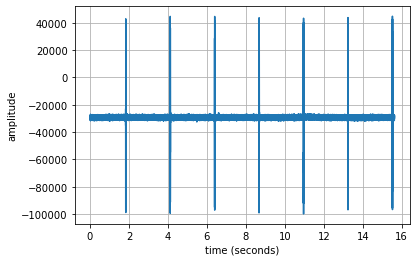

In [5]:
plt.plot(tvec[0:1000000],dat[0:1000000])
plt.xlabel('time (seconds)')
plt.ylabel('amplitude')
plt.grid()

Ok then, not bad for a first stab at this. We got some data loaded and plotted! That's great! But it is weird and noisy and not very exciting to look at so...

Next up: 
- figure out what those blips are every 2 seconds and determine whether I can easily filter them out. I'll probably start by exploring a spectrogram view
- use hvplot (etc) to make the plots in here interactive
- Decimation! (who needs 32 kHz anyway?? Anyone worth listening to is under 1 kHz, amirite??
- Pulling together multiple mseeds, decimating, pasting together?
- Maybe loop through multiple days of mseeds (or look at a few out of each day) and see if I can pull out interesting statistics or features (earthquakes? whale calls?)

## More web scraping
Circling back to the actual miniseed files - I want to see how hard it would be (or really how long it would take) to crawl through all of the folders for this instrument and just have a summary of where they all are (path and file name), and the start dates and times so you could more easily see what's available and choose what to look at.

--> UPDATE: I moved this over to a separate function since it's way too time consuming to do as part of this script. Writing it, it seems like this functionality must already exist, but it's still a good way to familiarize with the dataset and the data organization

In [ ]:
# # Create a dataframe to hold the data file path/time information 
# # (miniseed file name does not contain end time, so removed that column. 
# # maybe there's another way to get that info without actually opening the 
# # file)
# df_bb = pd.DataFrame(columns=['filepath','filename','starttime'])

# # Define the top level folder for this instrument/site (Axial volcano broadband hydrophone)
# main_url = 'https://rawdata.oceanobservatories.org/files/RS03AXBS/LJ03A/09-HYDBBA302/'
# main_url_contents = requests.get(main_url).content
# # Parse the main page using beautiful soup
# soup = BeautifulSoup(main_url_contents, 'html.parser')
# year_folders = [link.get('href') for link in soup.find_all('a')][6:]
# # year_folders should be just a list like: ['2015/', '2016/', '2017/', '2018/', '2019/', '2020/']

# # Loop through each year folder
# for yf in year_folders:
#     year_url = main_url + yf
#     year_url_contents = requests.get(year_url).content
#     soup = BeautifulSoup(year_url_contents, 'html.parser')
#     month_folders = [link.get('href') for link in soup.find_all('a')][6:]
    
#     # Loop through each month folder
#     for mf in month_folders:
#         month_url = year_url + mf
#         month_url_contents = requests.get(month_url).content
#         soup = BeautifulSoup(month_url_contents, 'html.parser')
#         day_folders = [link.get('href') for link in soup.find_all('a')][6:]
        
#         # Loop through each day folder
#         for df in day_folders:
#             day_url = month_url + df
#             day_url_contents = requests.get(day_url).content
#             soup = BeautifulSoup(day_url_contents, 'html.parser')
#             all_links = [link.get('href') for link in soup.find_all('a')]
#             mseed_files = [i for i in all_links if '.mseed' in i]
            
#             # For each miniseed file, add row to dataframe with file path, 
#             # file name, start and end date/time
#             for msfile in mseed_files:
#                 stime = parser.parse(msfile.split('.mseed')[0][-26:])
#                 df_bb = df_bb.append({'filepath': day_url,
#                                'filename': msfile.split('./')[1],
#                                'starttime': stime}, ignore_index=True)
            
# df_bb.to_pickle('../../data/ooi_lookup/ooi_lookup.pkl')          